<a href="https://colab.research.google.com/github/therealhaseeb/Email-Classification/blob/main/emails_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras==2.2.4 # critical dependency
!pip install bert-tensorflow==1.0.1
# !pip uninstall tensorflow
!pip install tensorflow==1.15.0

      Successfully uninstalled tensorflow-2.5.0


In [2]:
!pip freeze > r.txt

Write requirements to file, anytime you run it, in case you have to go back and recover dependencies.

Latest known such requirements are hosted for each notebook in the companion github repo, and can be pulled down and installed here if needed. Companion github repo is located at https://github.com/azunre/transfer-learning-for-nlp

In [3]:
# Import neural network libraries
import tensorflow as tf
import tensorflow_hub as hub
from bert.tokenization import FullTokenizer
from tensorflow.keras import backend as K

# Initialize session
sess = tf.compat.v1.Session()

In [4]:
# Some other key imports
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [6]:
!kaggle datasets download -d rtatman/fraudulent-email-corpus

 91% 5.00M/5.52M [00:00<00:00, 11.1MB/s]
100% 5.52M/5.52M [00:00<00:00, 11.2MB/s]


In [7]:
!kaggle datasets download -d wcukierski/enron-email-dataset

 95% 340M/358M [00:11<00:00, 34.3MB/s]
100% 358M/358M [00:11<00:00, 32.8MB/s]


In [8]:
!unzip /content/enron-email-dataset.zip

Archive:  /content/enron-email-dataset.zip
  inflating: emails.csv              


In [9]:
!unzip /content/fraudulent-email-corpus.zip

Archive:  /content/fraudulent-email-corpus.zip
  inflating: fradulent_emails.txt    


In [10]:
! rm /content/enron-email-dataset.zip /content/fraudulent-email-corpus.zip

# Define Tokenization, Stop-word and Punctuation Removal Functions
Before proceeding, we must decide how many samples to draw from each class. We must also decide the maximum number of tokens per email, and the maximum length of each token. This is done by setting the following overarching hyperparameters

In [11]:
# Params for bert model and tokenization
Nsamp = 500 # number of samples to generate in each class - 'spam', 'not spam'
maxtokens = 200 # the maximum number of tokens per document
maxtokenlen = 100 # the maximum length of each token

**Tokenization**

In [12]:
def tokenize(row):
    if row is None or row is '':
        tokens = ""
    else:
        try:
            tokens = row.split(" ")[:maxtokens]
        except:
            tokens=""
    return tokens

**Use regular expressions to remove unnecessary characters**

Next, we define a function to remove punctuation marks and other nonword characters (using regular expressions) from the emails with the help of the ubiquitous python regex library. In the same step, we truncate all tokens to hyperparameter maxtokenlen defined above.

In [13]:
def reg_expressions(row):
    tokens = []
    try:
        for token in row:
            token = token.lower()
            token = re.sub(r'[\W\d]', "", token)
            token = token[:maxtokenlen] # truncate token
            tokens.append(token)
    except:
        token = ""
        tokens.append(token)
    return tokens

**Stop-word removal**

Let’s define a function to remove stopwords - words that occur so frequently in language that they offer no useful information for classification. This includes words such as “the” and “are”, and the popular library NLTK provides a heavily-used list that will employ.

In [14]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')    
print(stopwords) # see default stopwords

def stop_word_removal(row):
    token = [token for token in row if token not in stopwords]
    token = filter(None, token)
    return token

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

# Read and Preprocess Enron dataset
Read Enron dataset and get a sense for the data by printing sample messages to screen

In [15]:
# Input data files are available in the "../input/" directory.
filepath = "/content/emails.csv"

# Read the data into a pandas dataframe called emails
emails = pd.read_csv(filepath, nrows=10000)

print("Successfully loaded {} rows and {} columns!".format(emails.shape[0], emails.shape[1]))
print(emails.head())

Successfully loaded 10000 rows and 2 columns!
                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


In [16]:
# Separate headers from the message bodies
import email

def extract_messages(df):
    messages = []
    for item in df["message"]:
        # Return a message object structure from a string
        e = email.message_from_string(item)    
        # get message body  
        message_body = e.get_payload()
        messages.append(message_body)
    print("Successfully retrieved message body from e-mails!")
    return messages

bodies = extract_messages(emails)

Successfully retrieved message body from e-mails!


In [17]:
import random


bodies_df = pd.DataFrame(random.sample(bodies, 9000))

pd.set_option('display.max_colwidth', 300)

bodies_df.head()

,0
0,"Our initial proposal will be for them to keep all their commission and incremental float, and for Enron to keep our spread. We have talked about it quite a bit and I expect that they will ask for more than this, but we would hesitate giving them the ability to widen our spreads as this could wo..."
1,This request has been pending your approval for 116 days. Please click http://itcapps.corp.enron.com/srrs/auth/emailLink.asp?ID=000000000041547&Page=Approval to review and act upon this request.\n\n\n\n\n\nRequest ID : 000000000041547\nRequest Create Date : 6/19/01 7:50:30 AM\nRequest...
2,"Starting tomorrow, 11/28/01 we will be included with the Gas Breakfast and Lunches. However, there will be a cost of $5.00 each or $10.00 total when breakfast is provided. They will have lunch everyday and breakfast only three days of the month, which will be during bid week. \n\nI will come ..."
3,"Susan,\n\nRaised your issue to Sally Beck. Larry is going to spend time with you to \nsee if he can live without any reports. Also some IT help should be on the \nway.\n\nPhillip"
4,"can you build something to look at historical prices from where we saved \ncurves each night.\n\nHere is an example that pulls socal only.\nImprovements could include a drop down menu to choose any curve and a choice \nof index,gd, or our curves.\n\n"


The following (commented out) code is arguably the more "pythonic" way of achieving the extraction of bodies from messages. It is only 2 lines long and achieves the same result. However, we feel the code above is more transparent with regards to how the processing is carried out, and as such leave this here for the python experts if they prefer.

# Read and Preprocess Fraudulent "419" Email Corpus

In [18]:
filepath = "/content/fradulent_emails.txt"
with open(filepath, 'r',encoding="latin1") as file:
    data = file.read()
    
# split on a code word appearing close to the beginning of each email
fraud_emails = data.split("From r")

print("Successfully loaded {} spam emails!".format(len(fraud_emails)))

Successfully loaded 3978 spam emails!


In [19]:
fraud_bodies = extract_messages(pd.DataFrame(fraud_emails,columns=["message"],dtype=str))
fraud_bodies_df = pd.DataFrame(fraud_bodies[1:1000])

fraud_bodies_df.head() # you could do print(fraud_bodies_df.head()), but Jupyter displays this nicer for pandas DataFrames

Successfully retrieved message body from e-mails!


,0
0,"FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-27-587908.\nE-MAIL: (james_ngola2002@maktoob.com).\n\nURGENT BUSINESS ASSISTANCE AND PARTNERSHIP.\n\n\nDEAR FRIEND,\n\nI AM ( DR.) JAMES NGOLA, THE PERSONAL ASSISTANCE TO THE LATE CONGOLESE (PRESIDENT LAURENT KABILA) WHO WAS ASSASSINATED BY HIS BODY G..."
1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom officer and work as Assistant controller of the Customs and Excise department Of the Federal Ministry of Internal Affairs stationed at the Murtala Mohammed International Airport, Ikeja, Lagos-Nigeria.\n\nAfter the sudden death of the former Head of s..."
2,"FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF ELEME KINGDOM \nCHIEF DANIEL ELEME, PHD, EZE 1 OF ELEME.E-MAIL \nADDRESS:obong_715@epatra.com \n\nATTENTION:PRESIDENT,CEO Sir/ Madam. \n\nThis letter might surprise you because we have met\nneither in person nor by correspondence. But I believe\nit is..."
3,"FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF ELEME KINGDOM \nCHIEF DANIEL ELEME, PHD, EZE 1 OF ELEME.E-MAIL \nADDRESS:obong_715@epatra.com \n\nATTENTION:PRESIDENT,CEO Sir/ Madam. \n\nThis letter might surprise you because we have met\nneither in person nor by correspondence. But I believe\nit is..."
4,"Dear sir, \n \nIt is with a heart full of hope that I write to seek your help in respect of the context below. I am Mrs. Maryam Abacha the former first lady of the former Military Head of State of Nigeria General Sani Abacha whose sudden death occurred on 8th of June 1998 as a result of cardiac ..."


# Putting It All Together To Assemble Dataset

Now, putting all the preprocessing steps together we assemble our dataset...

In [20]:
import random

# Convert everything to lower-case, truncate to maxtokens and truncate each token to maxtokenlen
EnronEmails = bodies_df.iloc[:,0].apply(tokenize)
EnronEmails = EnronEmails.apply(stop_word_removal)
EnronEmails = EnronEmails.apply(reg_expressions)
EnronEmails = EnronEmails.sample(Nsamp)

SpamEmails = fraud_bodies_df.iloc[:,0].apply(tokenize)
SpamEmails = SpamEmails.apply(stop_word_removal)
SpamEmails = SpamEmails.apply(reg_expressions)
SpamEmails = SpamEmails.sample(Nsamp)

raw_data = pd.concat([SpamEmails,EnronEmails], axis=0).values

In [21]:
print("Shape of combined data represented as numpy array is:")
print(raw_data.shape)
print("Data represented as numpy array is:")
print(raw_data)

# corresponding labels
Categories = ['spam','notspam']
header = ([1]*Nsamp)
header.extend(([0]*Nsamp))

Shape of combined data represented as numpy array is:
(1000,)
Data represented as numpy array is:
[list(['email', 'address', 'williammabayenetscapenettelephone', 'number', 'dear', 'friend', 'i', 'wish', 'begin', 'way', 'introduction', 'i', 'william', 'mabaye', 'first', 'surviving', 'son', 'late', 'tutu', 'mabaye', 'one', 'foremost', 'rich', 'black', 'farmers', 'zimbabwe', 'recently', 'murdered', 'land', 'dispute', 'country', 'before', 'death', 'father', 'taken', 'johannesburgsouth', 'africa', 'deposit', 'sum', 'us', 'million', 'tweenty', 'five', 'million', 'united', 'states', 'dollars', 'one', 'private', 'security', 'companies', 'family', 'valuables', 'realized', 'looming', 'danger', 'zimbabwe', 'this', 'amount', 'meant', 'purchase', 'new', 'machineries', 'chemicals', 'farms', 'also', 'establishment', 'new', 'farms', 'swazilandthis', 'land', 'dispute', 'started', 'president', 'robert', 'mugabe', 'introduced', 'new', 'land', 'reform', 'particularly', 'targeted', 'rich', 'white', 'farmer

In [22]:
# function for shuffling data in unison with labels/header
def unison_shuffle(a, b):
    p = np.random.permutation(len(b))
    data = a[p]
    header = np.asarray(b)[p]
    return data, header

# function for converting data into the right format, due to the difference in required format from sklearn models
# we expect a single string per email here, versus a list of tokens for the sklearn models previously explored
def convert_data(raw_data,header):
    converted_data, labels = [], []
    for i in range(raw_data.shape[0]):
        out = ' '.join(raw_data[i])
        converted_data.append(out)
        labels.append(header[i])
        #print(i)
    converted_data = np.array(converted_data, dtype=object)[:, np.newaxis]
    
    return converted_data, np.array(labels)

raw_data, header = unison_shuffle(raw_data, header)

# split into independent 70% training and 30% testing sets
idx = int(0.7*raw_data.shape[0])
# 70% of data for training
train_x, train_y = convert_data(raw_data[:idx],header[:idx])
# remaining 30% for testing
test_x, test_y = convert_data(raw_data[idx:],header[idx:])

print("train_x/train_y list details, to make sure it is of the right form:")
print(len(train_x))
print(train_x)
print(train_y[:5])
print(train_y.shape)

train_x/train_y list details, to make sure it is of the right form:
700
[['dear sirfirst i must solicit confidence transaction virtue its nature confidential i senior manager commercial bank  i came know private search reliable reputable person handle confidential transaction involves transfer huge sum money foreign countrythe prepositionthe late jerry adams foreigner oil merchant  contractor federal government nigeria death four years ago plane crash banked us closing balance usd ten million united states dollarsthe bank unquestionably expect claimed jerry adams next kin efforts made bank get touch adams family avail it perceived possibility able locate jerry adams next kin nok management influence executive director agreed since incident occurred  left fund dormant devalued transfer fund overseas utilize']
 ['']
 ['']
 ['attentiona  sirc i dre mrs mariam abacha wife late nigerian head statec general sani abacha died th june  active dutye i contacting view fact great assistance otherc

## Preprocessing

In [23]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


def create_tokenizer_from_hub_module(bert_path):
    """Get the vocab file and casing info from the Hub module."""
    bert_module = hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [tokenization_info["vocab_file"], tokenization_info["do_lower_case"]]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)


def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label


def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )


def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

Next, we define a custom tf hub BERT layer

## BERT Sentences to Feature Vectors

In [24]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="mean",
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            pooled = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)
        else:
            raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")

        return pooled

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

We now use the custom TF hub BERT embedding layer within a higher-level function to define the overall model. More specifically, we put a dense trainable layer of output dimension 256 on top of the BERT embedding.

In [25]:
# Function to build overall model
def build_model(max_seq_length):
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    # just extract BERT features, don't fine-tune
    bert_output = BertLayer(n_fine_tune_layers=0)(bert_inputs)
    # train dense classification layer on top of extracted features
    dense = tf.keras.layers.Dense(256, activation="relu")(bert_output)
    pred = tf.keras.layers.Dense(1, activation="sigmoid")(dense)

    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()

    return model

# Function to initialize variables correctly
def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [26]:
# tf hub bert model path
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1" 

# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module(bert_path)

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_x, train_y)
test_examples = convert_text_to_examples(test_x, test_y)

# Convert to features
(train_input_ids,train_input_masks,train_segment_ids,train_labels) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=maxtokens)
(test_input_ids,test_input_masks,test_segment_ids,test_labels) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=maxtokens)

# Build model
model = build_model(maxtokens)

# Instantiate variables
initialize_vars(sess)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore



Converting examples to features: 100%|██████████| 300/300 [00:00<00:00, 359.90it/s]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]            

In [28]:
# Train model
history = model.fit([train_input_ids, train_input_masks, train_segment_ids],train_labels,
                    validation_data=([test_input_ids, test_input_masks, test_segment_ids],test_labels),
                    epochs=1, batch_size=32)

Train on 700 samples, validate on 300 samples
700/700 [==============================] - 1068s 2s/sample - loss: 0.1899 - acc: 0.9743 - val_loss: 0.1085 - val_acc: 0.9733


In [29]:
model.save('bert.h5')
reconstructed_model = keras.models.load_model("bert.h5")

NotImplementedError: ignored

In [30]:
eval = model.evaluate([test_input_ids, test_input_masks, test_segment_ids],test_labels)
print("Accuracy:", eval[1], '\nLoss:', eval[0])

300/300 [==============================] - 273s 909ms/sample - loss: 0.1085 - acc: 0.9733
Accuracy: 0.97333336 
Loss: 0.10847192893425624


**Visualize Convergence**

In [ ]:
plot_confusion_matrix(model, test_input_ids,test_labels)
plot_roc_curve(model, test_input_ids,test_labels)

In [ ]:
import matplotlib.pyplot as plt

df_history = pd.DataFrame(history.history)
fig,ax = plt.subplots()
plt.plot(range(df_history.shape[0]),df_history['val_acc'],'bs--',label='validation')
plt.plot(range(df_history.shape[0]),df_history['acc'],'r^--',label='training')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('BERT Email Classification Training')
plt.legend(loc='best')
plt.grid()
plt.show()

fig.savefig('BERTConvergence.png', format='png')

# Random Forest Regression

In [32]:
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')


regr = RandomForestClassifier(max_depth=10, random_state=0)
regr.fit(train_input_ids,train_labels)

# Use the forest's predict method on the test data
predictions_cat = regr.predict(test_input_ids)

from sklearn.metrics import accuracy_score

acc = accuracy_score(test_labels, predictions_cat)
print('Accuracy -', round(acc*100, 3), '%')

Accuracy - 87.0 %


In [33]:
from sklearn.metrics import plot_roc_curve, confusion_matrix, plot_confusion_matrix

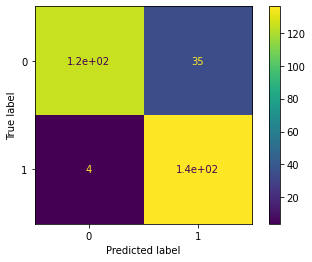

In [34]:
plot_confusion_matrix(regr, test_input_ids,test_labels)

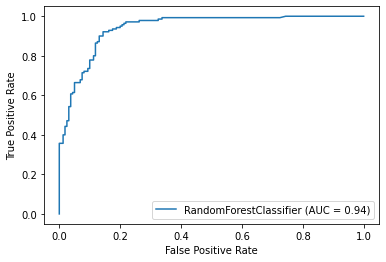

In [35]:
a = plot_roc_curve(regr, test_input_ids,test_labels)

# Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')


reg = LogisticRegression().fit(train_input_ids, train_labels)

predictions_cat2 = reg.predict(test_input_ids)


acc = accuracy_score(test_labels, predictions_cat2)
print('Accuracy -', round(acc*100, 3), '%')

Accuracy - 70.0 %


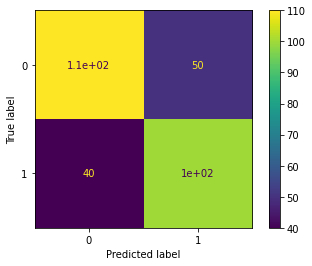

In [37]:
plot_confusion_matrix(reg, test_input_ids,test_labels)

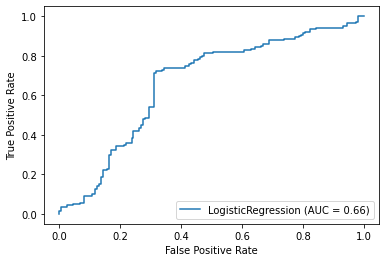

In [38]:
a = plot_roc_curve(reg, test_input_ids,test_labels)

# Support Vector Machine

In [39]:
from sklearn.svm import SVC
warnings.filterwarnings('ignore')


svr = SVC().fit(train_input_ids, train_labels)

predictions_cat3 = svr.predict(test_input_ids)

acc = accuracy_score(test_labels, predictions_cat3)
print('Accuracy -', round(acc*100, 3), '%')

Accuracy - 80.0 %


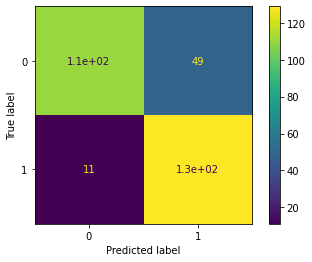

In [40]:
plot_confusion_matrix(svr, test_input_ids,test_labels)

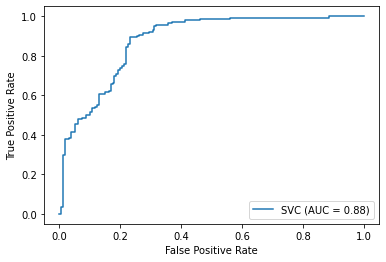

In [41]:
a = plot_roc_curve(svr, test_input_ids,test_labels)

# Adaboost

In [42]:
from sklearn.ensemble import AdaBoostClassifier


clf = AdaBoostClassifier(n_estimators=10)
clf.fit(train_input_ids, train_labels)

predictions_cat4 = clf.predict(test_input_ids)

acc = accuracy_score(test_labels, predictions_cat4)
print('Accuracy -', round(acc*100, 3), '%')

Accuracy - 83.667 %


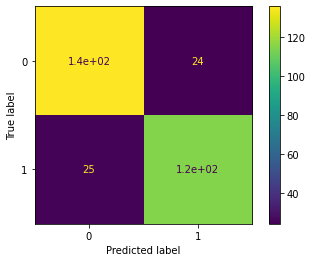

In [43]:
plot_confusion_matrix(clf, test_input_ids,test_labels)

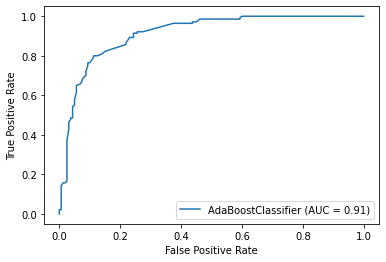

In [44]:
a = plot_roc_curve(clf, test_input_ids,test_labels)